In [2]:
## system interfacting libs
import os
import shutil
# libs for text processing and cleaning
from bs4 import BeautifulSoup
import re

# data science libs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pprint import pprint
# interactive file downloads
from IPython.display import FileLink

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, AutoConfig
from datasets import Dataset, Value, ClassLabel, Features

# Loading extra neutral data to neutralize model decision making towards no mental disorder messages

In [4]:
# load data
emotion_df = pd.read_csv('/kaggle/input/emotions-dataset/emotions.csv')
suicide_df = pd.read_csv('/kaggle/input/suicide-watch/Suicide_Detection.csv')
suicide_df['label'] = suicide_df['class']

In [5]:
emotion_df = emotion_df.query("label in [1,2]")
suicide_df = suicide_df.query("label == 'non-suicide'")

In [6]:
emotion_df

,text,label
6,i would think that whomever would be lucky eno...,2
7,i fear that they won t ever feel that deliciou...,1
10,i try to be nice though so if you get a bitchy...,1
12,i have officially graduated im not feeling as ...,1
14,i feel my portfolio demonstrates how eager i a...,1
...,...,...
416800,i don t know why today i feel like it looks ve...,1
416801,i don t even feel like i fully resolved it but...,1
416802,i feel like i have been neglecting you my fait...,1
416803,i cry and feel a sense of loss when my patient...,1


In [7]:
suicide_df

,Unnamed: 0,text,class,label
1,3,Am I weird I don't get affected by compliments...,non-suicide,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,non-suicide
8,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,non-suicide
15,24,Fuck the verizon smart family app I can’t even...,non-suicide,non-suicide
17,26,"Well, Im screwed. I locked myself in the schoo...",non-suicide,non-suicide
...,...,...,...,...
232068,348101,I did something today I went sledding with my ...,non-suicide,non-suicide
232069,348103,If you don't like rock then your not going to ...,non-suicide,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,non-suicide


In [8]:
# label it as no-mental-disorder
emotion_df['subreddit'] = emotion_df['label'].map(lambda x: 'no-mental-disorder')
suicide_df['subreddit'] = suicide_df['label'].map(lambda x: 'no-mental-disorder')

In [9]:
emotion_df['post'] = emotion_df['text']
emotion_df = emotion_df[['post', 'subreddit']]

suicide_df['post'] = suicide_df['text']
suicide_df = suicide_df[['post', 'subreddit']]

# Loading extra datasets for representation balancing

# Loading the main dataset

In [10]:
df= pd.read_csv('/kaggle/input/mental-disorder-dataset-analysis/processed_mental_disorders.csv')

In [11]:
df = df.query('subreddit != "no-mental-disorder"')

In [12]:
df.head(5), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 363622 entries, 1890 to 561442
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    363622 non-null  int64 
 1   subreddit     363622 non-null  object
 2   post          363622 non-null  object
 3   sentence_len  363622 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 13.9+ MB


(      Unnamed: 0 subreddit                                               post  \
 1890        3080      adhd  Lethargic/Depressed when off meds First I'll g...   
 1891        3081      adhd  Concerta not working on the first day?! Update...   
 1892        3082      adhd  Comorbid anxiety and ADHD-PI Medication Questi...   
 1893        3083      adhd  Fist Day on Concerta 18mg UPDATE! Update!: Tha...   
 1894        3084      adhd  I absolutely hate being so motivated but equal...   
 
       sentence_len  
 1890           143  
 1891           141  
 1892           132  
 1893           128  
 1894            77  ,
 None,
           Unnamed: 0   sentence_len
 count  363622.000000  363622.000000
 mean   347960.434165      93.289702
 std    252840.748106      50.837490
 min         0.000000      20.000000
 25%    125461.500000      49.000000
 50%    302852.500000      87.000000
 75%    531327.750000     133.000000
 max    796105.000000     201.000000)

In [13]:
df['subreddit'].value_counts()

subreddit
depression         77680
anxiety            54023
jokes              42765
suicidewatch       37258
adhd               31901
mentalhealth       26936
bipolar            19801
OCD                17485
lonely             17255
autism             15700
eating-disorder    11450
schizophrenia       6110
ptsd                5258
Name: count, dtype: int64

In [14]:
df = df[['post', 'subreddit']]

In [15]:
df = pd.concat([df, emotion_df, suicide_df], ignore_index=True)

In [16]:
df

,post,subreddit
0,Lethargic/Depressed when off meds First I'll g...,adhd
1,Concerta not working on the first day?! Update...,adhd
2,Comorbid anxiety and ADHD-PI Medication Questi...,adhd
3,Fist Day on Concerta 18mg UPDATE! Update!: Tha...,adhd
4,I absolutely hate being so motivated but equal...,adhd
...,...,...
655275,I did something today I went sledding with my ...,no-mental-disorder
655276,If you don't like rock then your not going to ...,no-mental-disorder
655277,You how you can tell i have so many friends an...,no-mental-disorder
655278,pee probably tastes like salty tea😏💦‼️ can som...,no-mental-disorder


In [17]:
# checking text length
df['sen_len'] = df['post'].str.split().str.len()
df['sen_len'].describe()

count    655280.000000
mean         67.906612
std          76.734264
min           1.000000
25%          22.000000
50%          45.000000
75%         102.000000
max        8220.000000
Name: sen_len, dtype: float64

In [18]:
# dropping very long texts
q = df['sen_len'].quantile(0.95)
q

178.0

In [19]:
df = df.query("sen_len < @q")
df

,post,subreddit,sen_len
0,Lethargic/Depressed when off meds First I'll g...,adhd,143
1,Concerta not working on the first day?! Update...,adhd,141
2,Comorbid anxiety and ADHD-PI Medication Questi...,adhd,132
3,Fist Day on Concerta 18mg UPDATE! Update!: Tha...,adhd,128
4,I absolutely hate being so motivated but equal...,adhd,77
...,...,...,...
655275,I did something today I went sledding with my ...,no-mental-disorder,38
655276,If you don't like rock then your not going to ...,no-mental-disorder,19
655277,You how you can tell i have so many friends an...,no-mental-disorder,31
655278,pee probably tastes like salty tea😏💦‼️ can som...,no-mental-disorder,14


In [20]:
df.info(), df['subreddit'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 621736 entries, 0 to 655279
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   post       621736 non-null  object
 1   subreddit  621736 non-null  object
 2   sen_len    621736 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 19.0+ MB


(None,
 subreddit
 no-mental-disorder    284555
 depression             71376
 anxiety                49407
 jokes                  41795
 suicidewatch           34478
 adhd                   29422
 mentalhealth           24224
 bipolar                18027
 OCD                    16316
 lonely                 16165
 autism                 14606
 eating-disorder        10859
 schizophrenia           5739
 ptsd                    4767
 Name: count, dtype: int64)

In [21]:
# drop_duplicates
df = df.drop_duplicates(subset=['post'])
df

,post,subreddit,sen_len
0,Lethargic/Depressed when off meds First I'll g...,adhd,143
1,Concerta not working on the first day?! Update...,adhd,141
2,Comorbid anxiety and ADHD-PI Medication Questi...,adhd,132
3,Fist Day on Concerta 18mg UPDATE! Update!: Tha...,adhd,128
4,I absolutely hate being so motivated but equal...,adhd,77
...,...,...,...
655275,I did something today I went sledding with my ...,no-mental-disorder,38
655276,If you don't like rock then your not going to ...,no-mental-disorder,19
655277,You how you can tell i have so many friends an...,no-mental-disorder,31
655278,pee probably tastes like salty tea😏💦‼️ can som...,no-mental-disorder,14


In [22]:
# remove deleted posts
df = df.query("'[deleted]' not in post and '[removed]' not in post")

In [23]:
df.info(), df['subreddit'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 589263 entries, 0 to 655279
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   post       589263 non-null  object
 1   subreddit  589263 non-null  object
 2   sen_len    589263 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 18.0+ MB


(None,
 subreddit
 no-mental-disorder    274091
 depression             69041
 anxiety                46475
 jokes                  39031
 suicidewatch           31929
 adhd                   26717
 mentalhealth           21634
 OCD                    16250
 bipolar                16236
 lonely                 14724
 autism                 13849
 eating-disorder        10024
 schizophrenia           5084
 ptsd                    4178
 Name: count, dtype: int64)

In [24]:
df = df.dropna()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 589263 entries, 0 to 655279
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   post       589263 non-null  object
 1   subreddit  589263 non-null  object
 2   sen_len    589263 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 18.0+ MB


In [26]:
# pre-processing the input to remove special characters
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['post']= df['post'].apply(denoise_text)

/tmp/ipykernel_34/4122083109.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [27]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s\?!\n]' ## keeping letters, numbers, spaces, question marks and exclamation mark as they are important for emotion exrtaction
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
df ['post']= df['post'].apply(remove_special_characters)

In [28]:
df['post'].str.contains('\n').sum()

170853

In [29]:
# avoiding corrupted pandas save
df['post'] = df['post'].str.replace('\n', '').str.replace('\r', '')

In [30]:
df['post'].str.contains('\n').sum()

0

In [31]:
df['post'].head(5) ## confirming that 

0    LethargicDepressed when off meds First Ill giv...
1    Concerta not working on the first day?! Update...
2    Comorbid anxiety and ADHDPI Medication Questio...
3    Fist Day on Concerta 18mg UPDATE! Update! Than...
4    I absolutely hate being so motivated but equal...
Name: post, dtype: object

In [32]:
# filter the needed columns and analyse the new stats
df = df[['post', 'subreddit']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 589263 entries, 0 to 655279
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   post       589263 non-null  object
 1   subreddit  589263 non-null  object
dtypes: object(2)
memory usage: 13.5+ MB


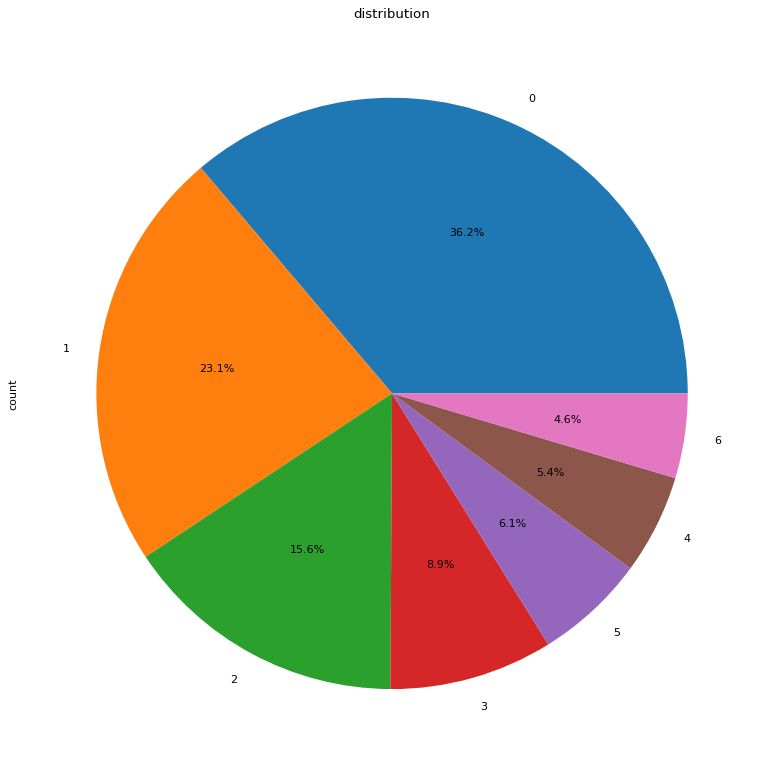

In [7]:
# distribution of labels (reddit conversations)
from matplotlib.pyplot import figure

def plot_class_dist(df: pd.DataFrame, col: str, title: str = 'distribution'):
    figure(figsize=(12, 12), dpi=80)

    counts = df[col].value_counts()
    # Create a pie chart
    counts.plot.pie(autopct="%1.1f%%")  # Add percentages to slices
    plt.title(title)
    plt.show()
    
plot_class_dist(df, 'subreddit')

In [50]:
pprint(df.query('subreddit == "OCD"').sample(n=10)['post'].values, width=1, compact=True)

array(['Idk if its my period that is making me anxious asf but im so scared im gonna have psychosis i havent done any drugs or have had extreme trauma or any mental illnesses that can cause psychosis but im scared im gonna hallucinate or hear things',
       'Im very open to explaining to my partner what OCD I deal with and how he can best support me during therapy Any tips on how he can help especially since I look for reassurance for my OCD?',
       'Is it possible that part of the trigger for intrusive thoughts is activated by us? I realized that automatically very often its myself that in a few milliseconds I have like a reminder that Im not having intrusive thoughts and then the next millisecond I create one for the occasion on what I was doing in that moment I have also noticed that pure intrusive thoughts are not even that annoying as they are random words to question my identity etc But the personalized ones like the last one are like Im causing them unintentionally of course 

In [14]:
# mapping the labels to corresponding integers to simplify usage of sparse categorical cross entropy
label_mapper = {
    'no-mental-disorder': 0,
    'depression': 1,
    'anxiety': 2,
    'adhd': 3,
    'bipolar': 4,
    'OCD': 5,
    'autism': 6
}

In [36]:
# removing unwanted labels
df = df.query("subreddit not in ['mentalhealth', 'lonely', 'eating-disorder', 'suicidewatch', 'schizophrenia', 'jokes', 'ptsd']")

In [ ]:
# mapping the labels
df['subreddit'] = df['subreddit'].copy().apply(lambda x: label_mapper[x])

In [37]:
df.info(), df['subreddit'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 467772 entries, 0 to 698105
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   post       467772 non-null  object
 1   subreddit  467772 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.7+ MB


(None,
 subreddit
 0    274329
 1     70116
 2     47266
 3     27129
 5     18379
 4     16520
 6     14033
 Name: count, dtype: int64)

In [38]:
# removing 60% of the no-mental-disorder labels randomly to balance the data
dropped_samples = df[df['subreddit'] == 0].sample(frac=0.50).index
df = df.drop(index=dropped_samples)

In [39]:
df.query('subreddit == 0').sample(n=30)

,post,subreddit
577824,i feel graceful where others might flounder st...,0
506744,i feel are more talented,0
642096,Day 69 of recommending songs httpsyoutubeSOFCQ...,0
617560,sometimes i just wanna rip out other peoples e...,0
536885,i think it helped make their new room here fee...,0
655696,uclayonnaise comment on this right now DO IT,0
487946,i have searched for a long time and found an e...,0
613861,Problem being camera shy For the past year Ive...,0
438643,i were to go overseas or cross the border then...,0
544645,i feel that it is dissastrous claiming many in...,0


In [40]:
df['subreddit'].value_counts()

subreddit
0    109732
1     70116
2     47266
3     27129
5     18379
4     16520
6     14033
Name: count, dtype: int64

In [41]:
df.to_csv('final_hierarichal.csv', index=False)

In [5]:
df = pd.read_csv('final_hierarichal.csv')

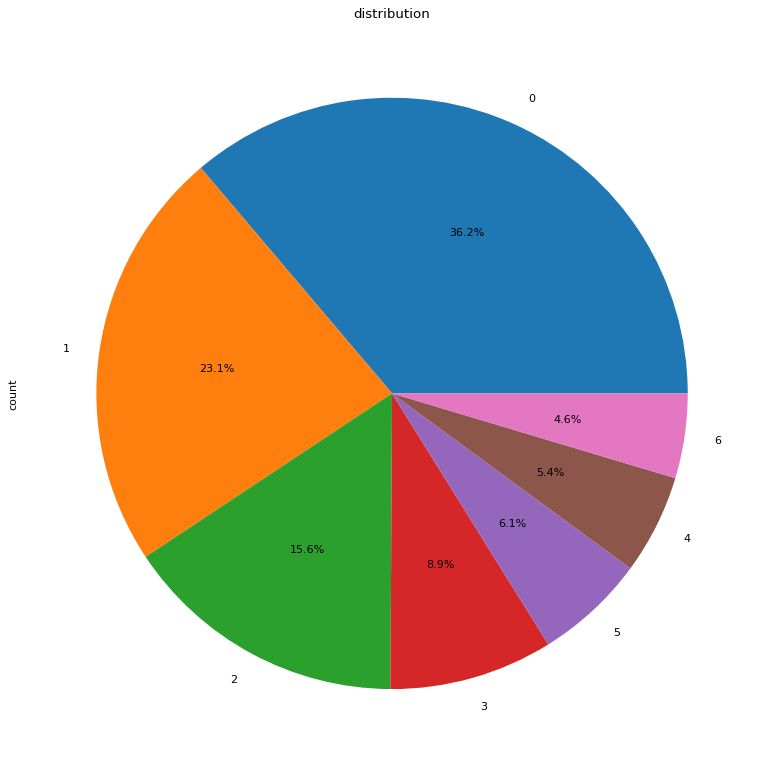

In [43]:
plot_class_dist(df, 'subreddit')

In [6]:
# splitting the data frame into 3 distinct subsets for train/valdiation/testing before stream loading the CSV through TensorFlow

X_train, X_val, y_train, y_val = train_test_split(df['post'], df['subreddit'], train_size=0.90, test_size=0.10, stratify=df['subreddit']) ## use higher splits for larger data
X_val, X_test, y_val, y_test  = train_test_split(X_val, y_val, train_size=0.7, test_size = 0.3, stratify=y_val)

train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.info(), val_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272857 entries, 44655 to 235144
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   post       272837 non-null  object
 1   subreddit  272857 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 21222 entries, 283139 to 98861
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   post       21220 non-null  object
 1   subreddit  21222 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 497.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 9096 entries, 179196 to 275169
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   post       9096 non-null   object
 1   subreddit  9096 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 213.2+ KB


(None, None, None)

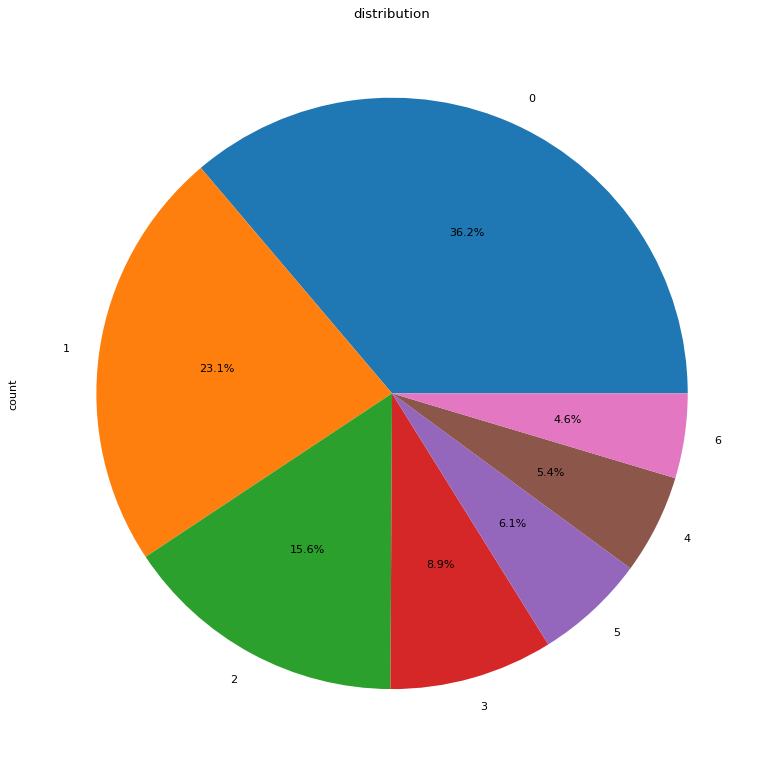

(None,
 subreddit
 0    98759
 1    63104
 2    42539
 3    24416
 5    16541
 4    14868
 6    12630
 Name: count, dtype: int64)

In [13]:
plot_class_dist(train_df, 'subreddit'), train_df['subreddit'].value_counts()

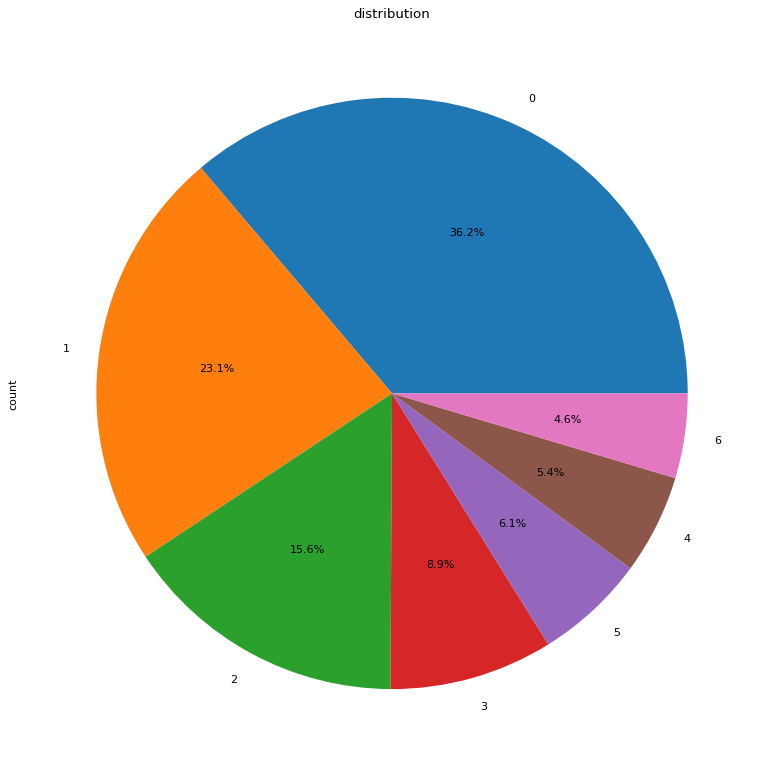

In [10]:
plot_class_dist(val_df, 'subreddit')

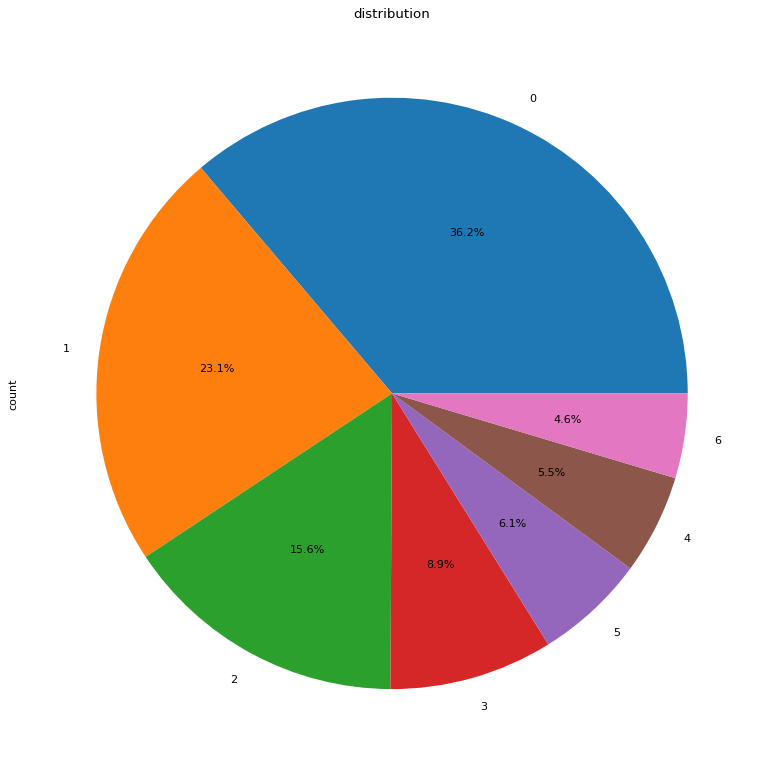

(None,
 subreddit
 0    3292
 1    2104
 2    1418
 3     814
 5     551
 4     496
 6     421
 Name: count, dtype: int64)

In [15]:
plot_class_dist(test_df, 'subreddit'), test_df['subreddit'].value_counts()

In [16]:
# saving training params inferred from data frames
TRAIN_SIZE = len(train_df)
VAL_SIZE = len(val_df)
TEST_SIZE = len(test_df)

In [17]:
from sklearn.utils.class_weight import compute_class_weight
# create class weights ONLY FROM TRAINING DATA to be used in weighted loss function
class_counts = train_df['subreddit'].value_counts()
sorted_counts  = [ (class_label, count) for class_label, count in sorted(class_counts.items(), key=lambda x: x[0])]
CLASS_WEIGHTS = compute_class_weight(class_weight='balanced', classes=[r[0] for r in sorted_counts], y= train_df['subreddit'])

In [18]:
sorted_counts

[(0, 98759),
 (1, 63104),
 (2, 42539),
 (3, 24416),
 (4, 14868),
 (5, 16541),
 (6, 12630)]

In [48]:
CLASS_WEIGHTS

array([0.39469387, 0.61770365, 0.91632552, 1.59647655, 2.62170914,
       2.35654262, 3.08626852])

In [19]:
train_df['labels'] = train_df['subreddit']
train_df['text'] = train_df['post']
train_df = train_df[['text', 'labels']]

val_df['labels'] = val_df['subreddit']
val_df['text'] = val_df['post']
val_df = val_df[['text', 'labels']]


test_df['labels'] = test_df['subreddit']
test_df['text'] = test_df['post']
test_df = test_df[['text', 'labels']]

In [20]:
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

# Creating the model

In [21]:
len(label_mapper.keys())

7

In [22]:
def get_ds(df: pd.DataFrame):
    
    df = Dataset.from_pandas(df.reset_index(drop=True))
    df = df.cast_column("labels", ClassLabel(num_classes=len(label_mapper.keys()), names=list(sorted(label_mapper.keys(), key= lambda x: label_mapper[x]))))
    return df

# Training loop

In [23]:
tokenizer = AutoTokenizer.from_pretrained("M-FAC/bert-tiny-finetuned-sst2")
config = AutoConfig.from_pretrained("M-FAC/bert-tiny-finetuned-sst2")
config.num_labels = len(label_mapper.keys())
model = AutoModelForSequenceClassification.from_config(config)


training_args = TrainingArguments(
    output_dir="checkpoints",  # Change this to your output directory
    overwrite_output_dir=True,
    num_train_epochs=40,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=256,
    learning_rate=2e-5,
    metric_for_best_model='f1',
    evaluation_strategy='steps',
    load_best_model_at_end=True,
    warmup_steps=300,
)

tokenizer_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [24]:
def preprocess(example):
    return tokenizer(example['text'], padding='max_length', max_length=200, truncation=True)


train_ds= get_ds(train_df).map(preprocess, batched=True)
val_ds= get_ds(val_df).map(preprocess, batched=True)
test_ds= get_ds(test_df).map(preprocess, batched=True)

Casting the dataset:   0%|          | 0/272837 [00:00<?, ? examples/s]

Map:   0%|          | 0/272837 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/21220 [00:00<?, ? examples/s]

Map:   0%|          | 0/21220 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9096 [00:00<?, ? examples/s]

Map:   0%|          | 0/9096 [00:00<?, ? examples/s]

In [25]:
train_ds.features['labels'], len(train_ds.features['labels'].names)

(ClassLabel(names=['no-mental-disorder', 'depression', 'anxiety', 'adhd', 'bipolar', 'OCD', 'autism'], id=None),
 7)

In [15]:
import wandb
wandb.init(mode="disabled")

In [29]:
from datasets import load_metric
acc = load_metric('accuracy')
f1 = load_metric('f1')
precision = load_metric('precision')
recall = load_metric('recall')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # classification predictions
    predictions = np.argmax(predictions, axis=1)
    
    return {
        'classification-accuracy': acc.compute(predictions=predictions, references=labels)['accuracy'],
        'detection-accuracy': acc.compute(predictions= (predictions ==0 ), references= (labels == 0))['accuracy'],
        'f1': f1.compute(predictions=predictions, references=labels, average='macro')['f1'],
        'precision': precision.compute(predictions=predictions, references=labels, average='macro')['precision'],
        'recall': recall.compute(predictions=predictions, references=labels, average='macro')['recall']
    }

/tmp/ipykernel_34/986053315.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  acc = load_metric('accuracy')
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [26]:
from torch import nn
import torch
from transformers import Trainer

class WeightedLossTrainer(Trainer):
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        
        detection_weight = 0.2
        # penalizing a wrong label overall
        class_loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(CLASS_WEIGHTS, dtype=torch.float32).cuda())
        class_loss = class_loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        # extra loss for mis detection of a mental disorder
        no_disorder_logits = logits[:, 0] ## probability of no mental disorder
        disorder_logits = torch.sum(logits[:, 1:], dim=1) ## probability of mental disorder as sum of all mental disorder logits
        
        all_disorder_logits = torch.cat([no_disorder_logits.unsqueeze(-1), disorder_logits.unsqueeze(-1)], dim=1)
        new_labels = (labels.view(-1) != 0).long()
        detection_loss_ft = nn.CrossEntropyLoss()
        detection_loss = detection_loss_ft(all_disorder_logits, new_labels)
        
        loss = detection_weight * detection_loss + (1 - detection_weight) * class_loss
        
        return (loss, outputs) if return_outputs else loss
        

2024-05-15 08:12:43.684086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 08:12:43.684200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 08:12:43.800640: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [161]:
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics= compute_metrics,
    tokenizer=tokenizer
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [154]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

In [162]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Classification-accuracy,Detection-accuracy,F1,Precision,Recall
500,1.625400,1.452894,0.377710,0.894581,0.200277,0.196074,0.265585
1000,1.360000,1.253923,0.504665,0.926202,0.329725,0.333642,0.388639
1500,1.184000,1.117782,0.573421,0.928464,0.451984,0.449418,0.488420
2000,1.044900,0.981561,0.667389,0.940481,0.575402,0.575347,0.591312
2500,0.937500,0.891411,0.719793,0.941093,0.643803,0.652428,0.659967
3000,0.864400,0.837123,0.739444,0.940575,0.669445,0.675966,0.688995
3500,0.810100,0.786920,0.757917,0.938266,0.692500,0.691568,0.716240
4000,0.763100,0.748294,0.774882,0.939491,0.709766,0.705117,0.730761
4500,0.719000,0.712053,0.783553,0.939774,0.718686,0.711163,0.739839
5000,0.681100,0.684933,0.787606,0.939538,0.722875,0.709887,0.748143


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, 

TrainOutput(global_step=10680, training_loss=0.7831637814696808, metrics={'train_runtime': 9635.5883, 'train_samples_per_second': 1132.622, 'train_steps_per_second': 1.108, 'total_flos': 5424632541840000.0, 'train_loss': 0.7831637814696808, 'epoch': 40.0})

In [163]:
trainer.evaluate(test_ds)

{'eval_loss': 0.6074739694595337,
 'eval_classification-accuracy': 0.8048592788038699,
 'eval_detection-accuracy': 0.9434916446789797,
 'eval_f1': 0.7427344434883182,
 'eval_precision': 0.7276535498614579,
 'eval_recall': 0.7686226791961103,
 'eval_runtime': 7.4894,
 'eval_samples_per_second': 1214.518,
 'eval_steps_per_second': 2.403,
 'epoch': 40.0}

In [5]:
!ls /kaggle/working/checkpoints/checkpoint-7000

config.json	   scheduler.pt		    trainer_state.json
model.safetensors  special_tokens_map.json  training_args.bin
optimizer.pt	   tokenizer.json	    vocab.txt
rng_state.pth	   tokenizer_config.json


In [27]:
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/checkpoints/checkpoint-10500")
model = AutoModelForSequenceClassification.from_pretrained('/kaggle/working/checkpoints/checkpoint-10500')

In [30]:
training_args = TrainingArguments(
    output_dir="checkpoints",  # Change this to your output directory
    overwrite_output_dir=True,
    num_train_epochs=40,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=256,
    learning_rate=2e-5,
    metric_for_best_model='f1',
    evaluation_strategy='steps',
    load_best_model_at_end=True,
    warmup_steps=300,
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics= compute_metrics,
    tokenizer=tokenizer
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [31]:
preds = trainer.predict(test_ds)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


[5 5 0 ... 0 0 0]


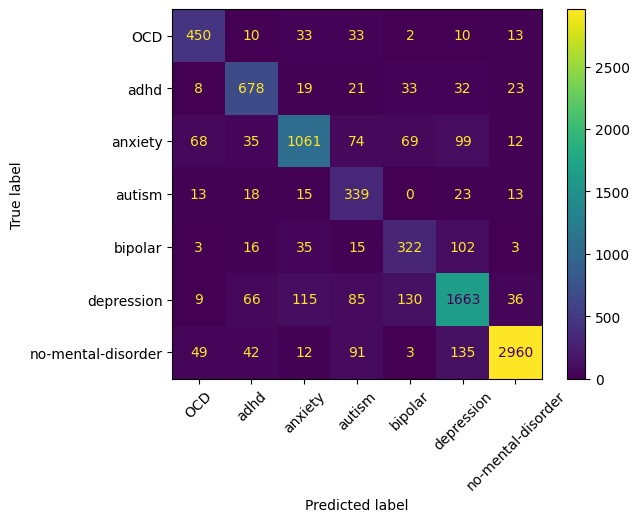

<Figure size 1200x1200 with 0 Axes>

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_pred = np.argmax(preds.predictions, axis=1)
y_test = preds.label_ids
print(y_test)
import matplotlib.pyplot as plt
disp = (ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=[ x[1] for x in sorted(label_mapper.items(), key= lambda x: x[0] )]), display_labels=sorted(list(label_mapper.keys()))))

disp.plot()

plt.xticks(rotation=45)
plt.figure(figsize=(12,12))
plt.show()

In [101]:
outputs = tokenizer(['That is a wonderful suggestion< I will take it into consideration and tell my friends about it'])
i_ids = outputs['input_ids']
tt_ids = outputs['token_type_ids']
at_mask = outputs['attention_mask']

In [102]:
import torch
out = model(input_ids=torch.tensor(i_ids), token_type_ids=torch.tensor(tt_ids), attention_mask=torch.tensor(at_mask)).logits

preds = torch.nn.functional.softmax(out).tolist()[0]

/tmp/ipykernel_34/2213861520.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = torch.nn.functional.softmax(out).tolist()[0]


In [103]:
from pprint import pprint
for  label, idx in (label_mapper.items()):
    pprint(f'{label}: {preds[idx]:.2%}')

'no-mental-disorder: 98.10%'
'depression: 0.21%'
'anxiety: 0.02%'
'adhd: 0.38%'
'bipolar: 0.03%'
'OCD: 0.77%'
'autism: 0.49%'


In [213]:
!ls /kaggle/working/checkpoints

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


checkpoint-1000   checkpoint-3000  checkpoint-5500  checkpoint-8500
checkpoint-10000  checkpoint-3500  checkpoint-6000  checkpoint-9000
checkpoint-10500  checkpoint-4000  checkpoint-6500  checkpoint-9500
checkpoint-1500   checkpoint-4500  checkpoint-7000  runs
checkpoint-2000   checkpoint-500   checkpoint-7500
checkpoint-2500   checkpoint-5000  checkpoint-8000


In [214]:
!zip ./model_v3 -r /kaggle/working/checkpoints/checkpoint-10500

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/checkpoints/checkpoint-10500/ (stored 0%)
  adding: kaggle/working/checkpoints/checkpoint-10500/rng_state.pth (deflated 25%)
  adding: kaggle/working/checkpoints/checkpoint-10500/model.safetensors (deflated 7%)
  adding: kaggle/working/checkpoints/checkpoint-10500/tokenizer_config.json (deflated 75%)
  adding: kaggle/working/checkpoints/checkpoint-10500/scheduler.pt (deflated 56%)
  adding: kaggle/working/checkpoints/checkpoint-10500/vocab.txt (deflated 53%)
  adding: kaggle/working/checkpoints/checkpoint-10500/optimizer.pt (deflated 22%)
  adding: kaggle/working/checkpoints/checkpoint-10500/config.json (deflated 54%)
  adding: kaggle/working/checkpoints/checkpoint-10500/training_args.bin (deflated 51%)
  adding: kaggle/working/checkpoints/checkpoint-10500/tokenizer.json (deflated 71%)
  adding: kaggle/working/checkpoints/checkpoint-10500/special_tokens_map.json (deflated 42%)
  adding: kaggle/working/checkpoints/checkpoint-10500/trainer_state.json (deflated 77

In [215]:
from IPython.display import FileLink

FileLink('model_v3.zip')

/kaggle/working/model_v3.zip